In [3]:
ON_KAGGLE = False

In [4]:
if not ON_KAGGLE:
    %load_ext autoreload
    %autoreload 2

    import sys
    sys.path.append('..')

In [5]:
import utilities

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns   
import matplotlib.pyplot as plt

from tqdm import tqdm

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_log_error

from matplotlib import colormaps

COLORS = utilities.ColorGenerator.COLORS

get_dummies_sex              = True
add_ratios_features          = False
add_interaction_shucked      = False
add_interaction_shell_weight = False
add_blood_weight_features    = False
perform_grid_search          = False

In [7]:
path_to_train = '/kaggle/input/playground-series-s4e4/train.csv' if ON_KAGGLE else 'train.csv'
path_to_test  = '/kaggle/input/playground-series-s4e4/test.csv'  if ON_KAGGLE else 'test.csv'

In [8]:
df_train = pd.read_csv(path_to_train)
df_test  = pd.read_csv(path_to_test)

In [9]:
# Rename column Whole weight.1 --> Shucked weight and Whole weight.2 --> Viscera weight
rename_mapping = {'Whole weight': 'Whole_weight', 'Shell weight': 'Shell_weight', 
                  'Whole weight.1': 'Shucked_weight', 'Whole weight.2': 'Viscera_weight'}

df_train = df_train.rename(columns=rename_mapping)
df_test = df_test.rename(columns=rename_mapping)

### DATA BASE INFOS

In [10]:
print('_______Train_______')
df_train.head()

_______Train_______


,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [11]:
print('_______Test_______')
df_test.head()

_______Test_______


,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [12]:
df_train.describe()

,id,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [13]:
df_test.describe()

,id,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000
mean,120820.000000,0.517428,0.401961,0.135751,0.790062,0.341227,0.169419,0.226125
std,17439.297893,0.117609,0.097470,0.038175,0.457591,0.204221,0.100720,0.129826
min,90615.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,105717.500000,0.450000,0.345000,0.110000,0.419500,0.178500,0.086500,0.120000
50%,120820.000000,0.545000,0.425000,0.140000,0.801500,0.329000,0.166000,0.225000
75%,135922.500000,0.600000,0.470000,0.160000,1.070000,0.464500,0.232500,0.305000
max,151025.000000,0.800000,0.650000,1.095000,2.825500,1.488000,0.641500,1.004000


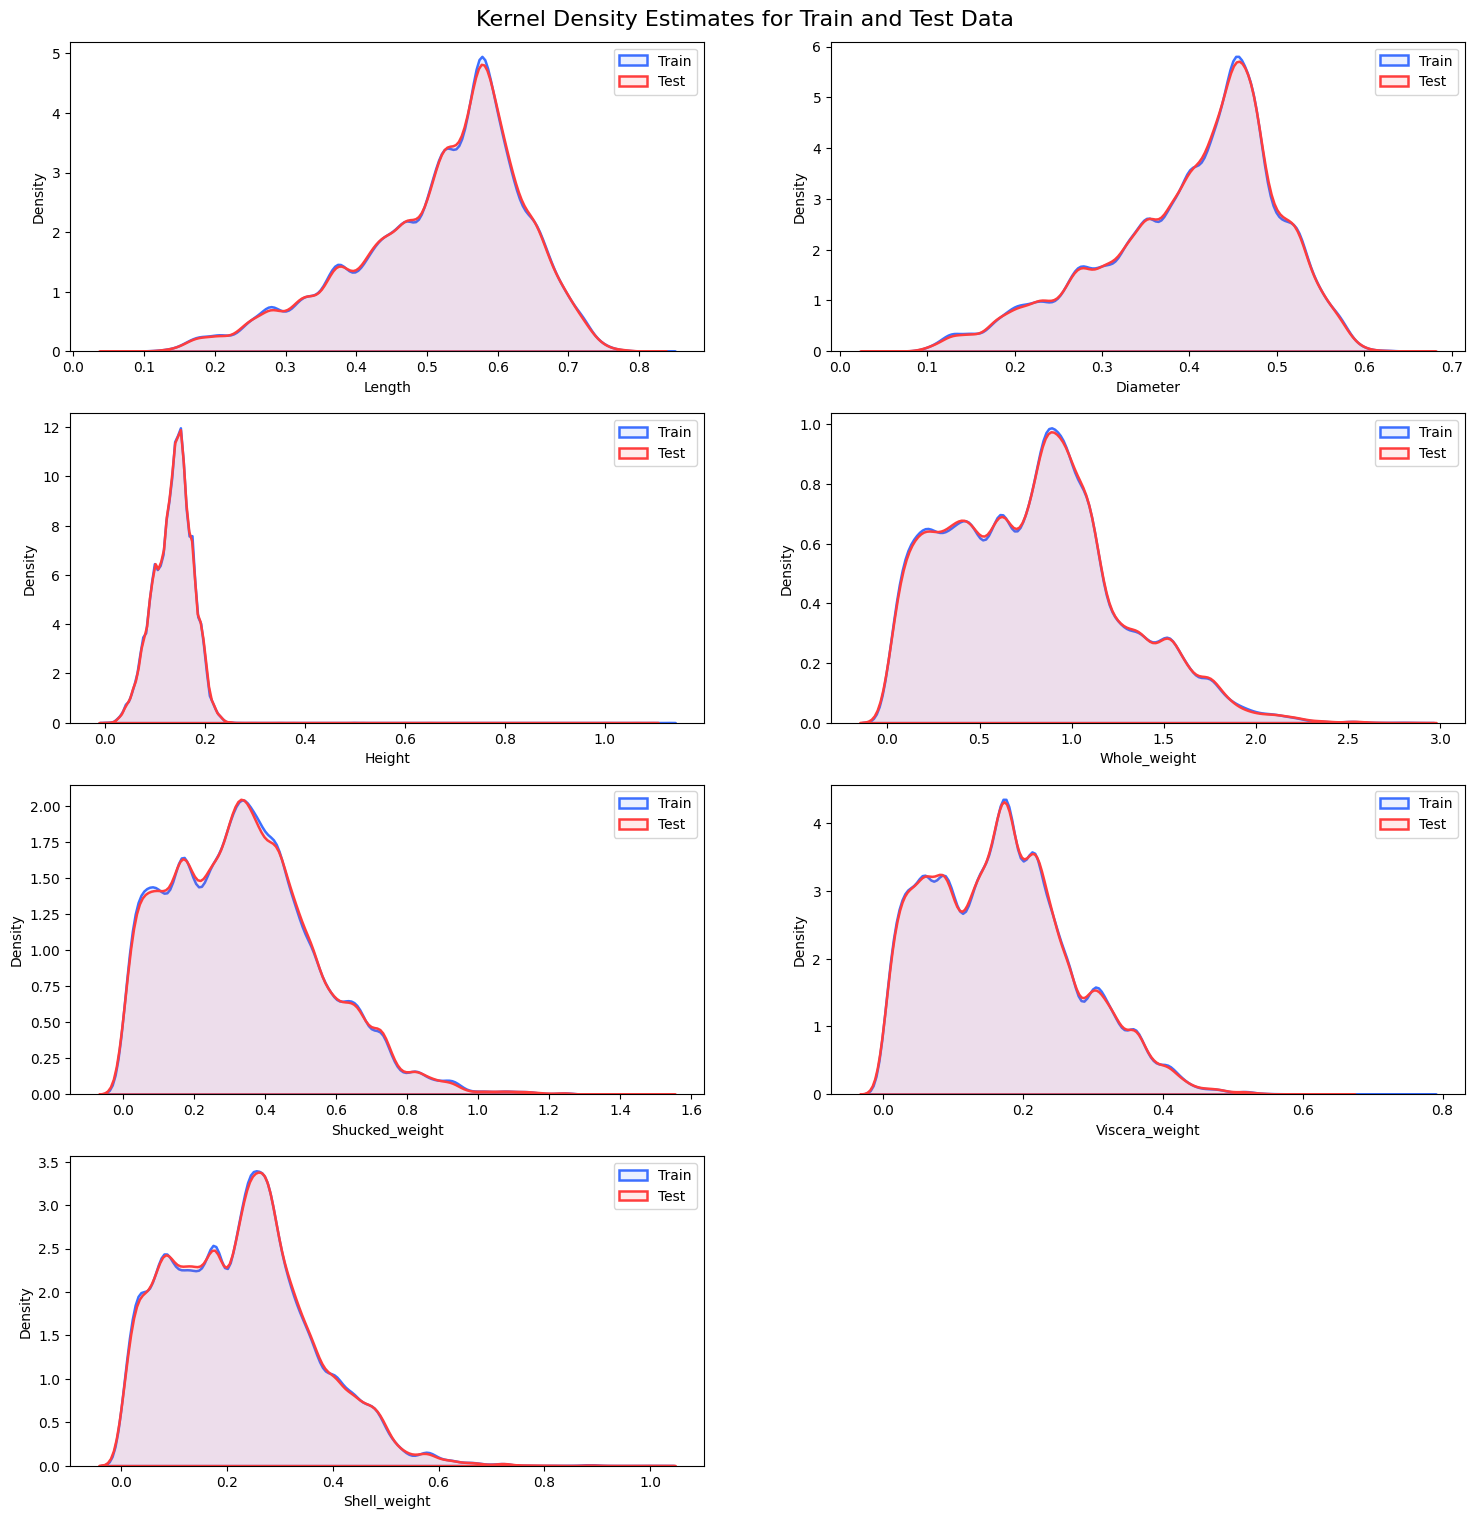

In [31]:
col_to_plot = df_test.drop(columns= ['id', 'Sex'], axis=1).columns

plt.figure(figsize=(18, 16))
plt.suptitle('Kernel Density Estimates for Train and Test Data', fontsize=16, y=1.02)
plt.subplots_adjust(top=1)
for i, col in enumerate(col_to_plot):
    ax = plt.subplot(4, 2, i+1)
    utilities.plot_kde(ax, [df_train, df_test], column=col, color=[COLORS['BLUE'], COLORS['RED']], labels=['Train', 'Test'], fill=True, alpha=0.1)

The distribution of train and test data are identical

Is there any missing data:

In [15]:
df_temp = pd.DataFrame([df_train.isnull().sum(), df_test.isnull().sum()], index=['TRAIN', 'TEST'])
df_temp

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
TRAIN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TEST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


No missing data!

### DATA ANALYSIS

Target distribution:

AttributeError: Rectangle.set() got an unexpected keyword argument 'add_value'

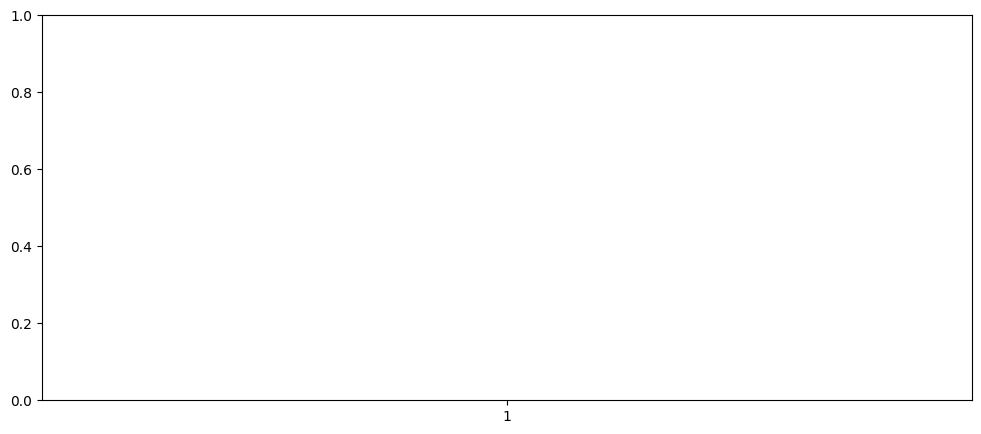

In [16]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(111)
target_distrib = utilities.plot_hist_discrete_feature(ax, df_train, 'Rings', color='YlGnBu', 
                                                      add_value=False, linewidth=0, alpha=0.95)

Here the distribution of the number of rings depending on the Sex:

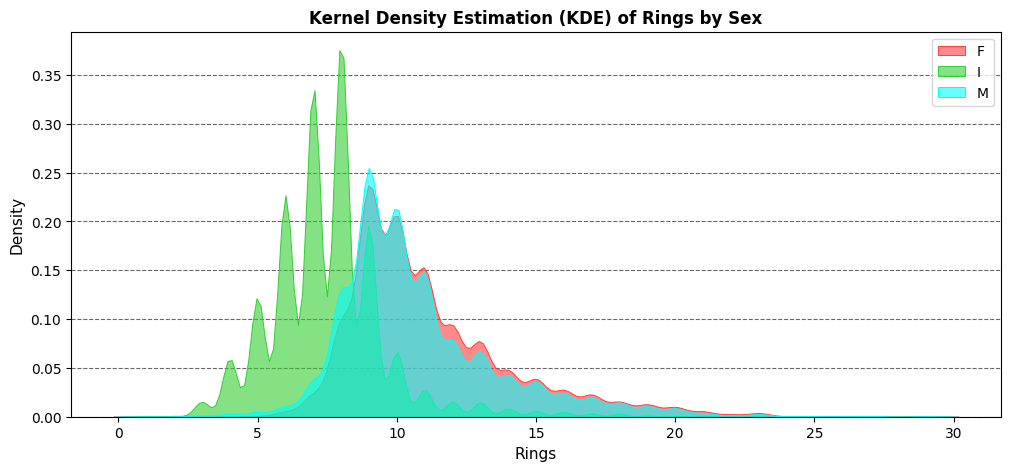

In [ ]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(111)
utilities.plot_kde(ax, df_train, 'Rings', group_column='Sex', 
                   color=[COLORS['RED'], COLORS['GREEN'], COLORS['CYAN']], fill=True)

Or here another viz with some boxplots of Rings attributes but also other columns of the train dataset to see their distribution depending on the Sex:

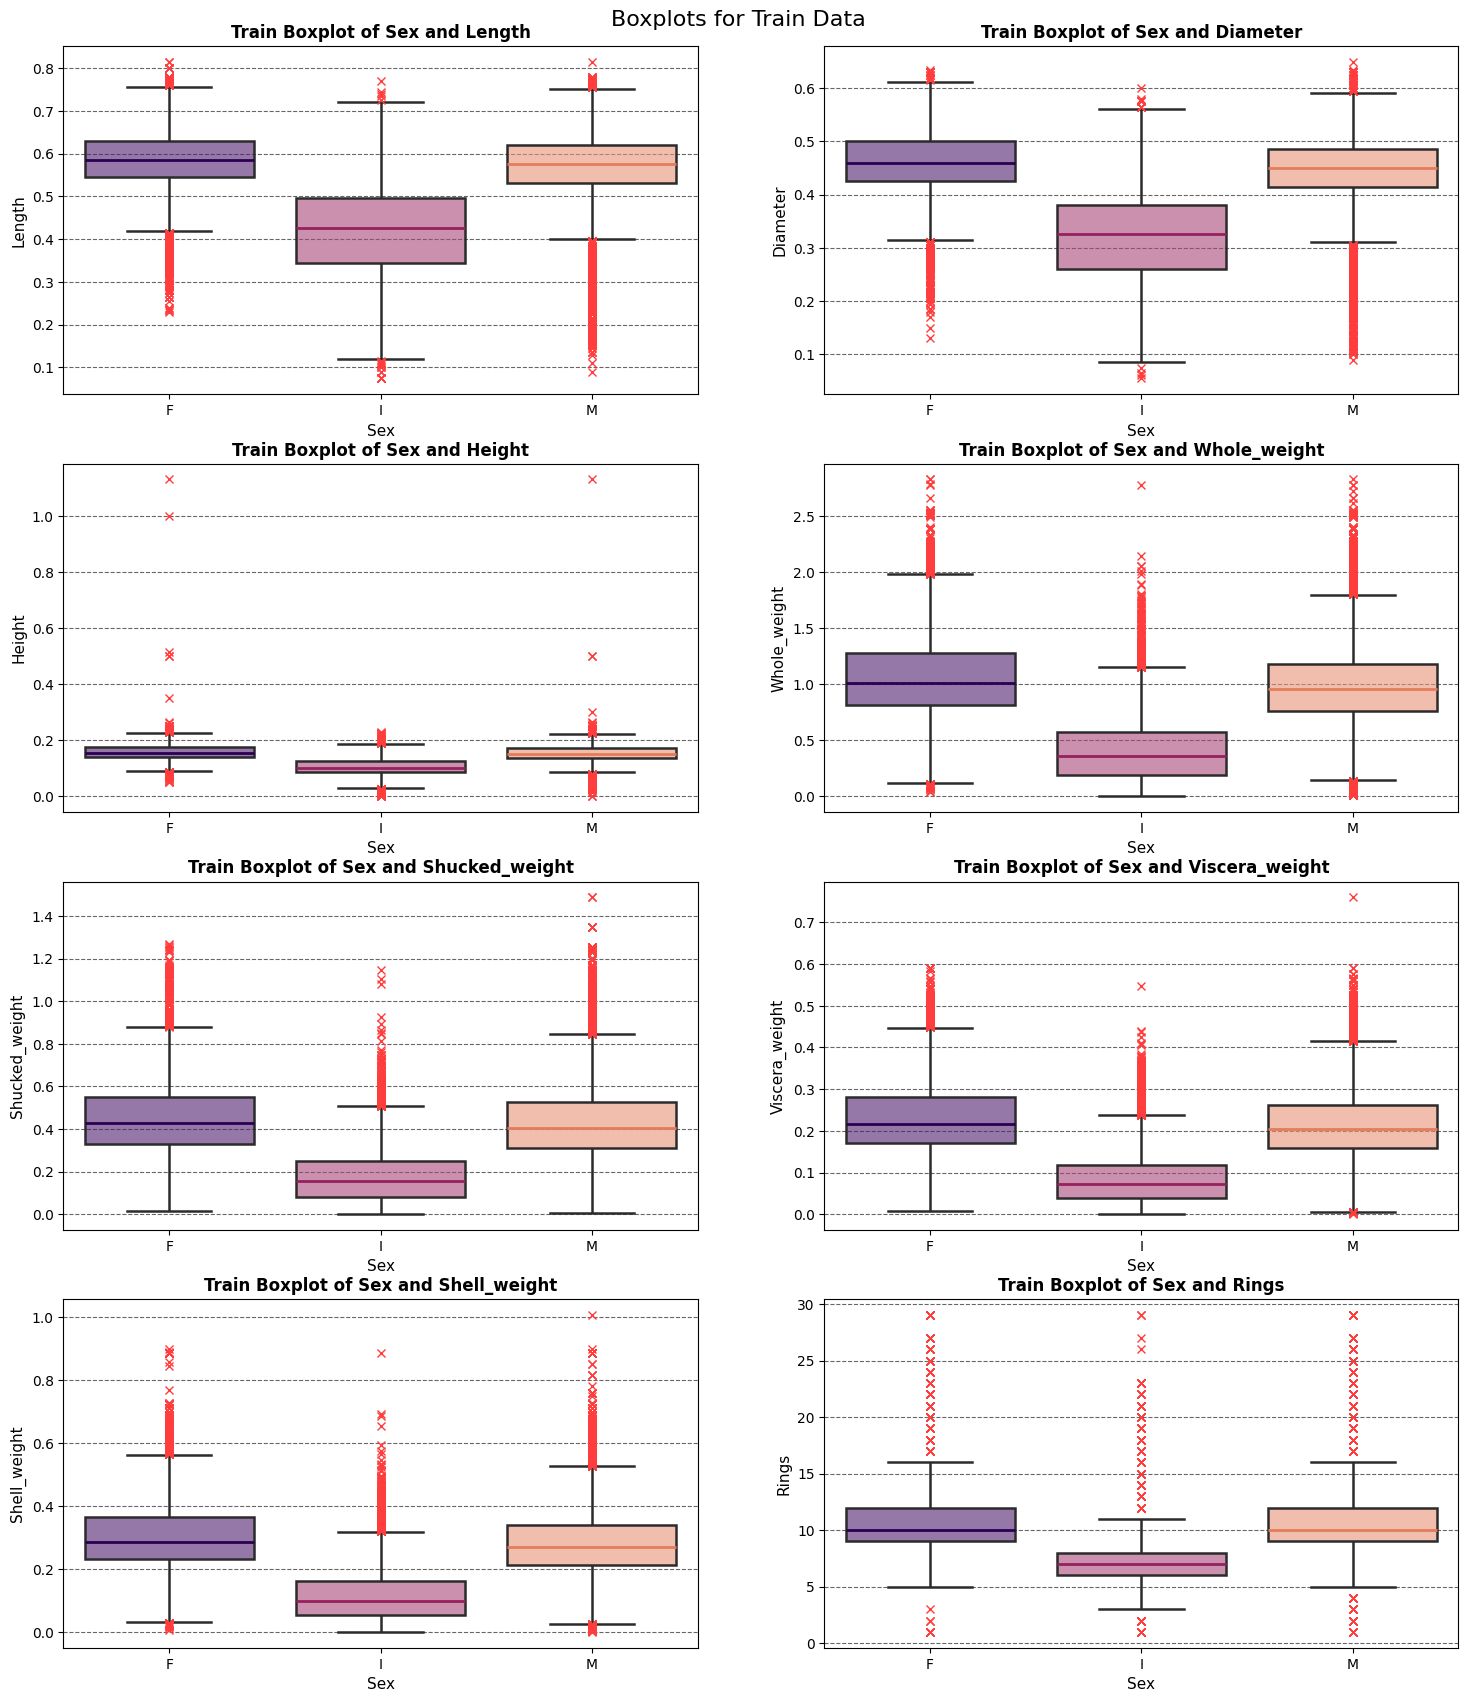

In [24]:
col_to_plot = df_train.drop(columns= ['id', 'Sex'], axis=1).columns

plt.figure(figsize=(18, 18))
plt.suptitle('Boxplots for Train Data', fontsize=16, y=1.02)
plt.subplots_adjust(top=1)
for i, col in enumerate(col_to_plot):
    ax = plt.subplot(4, 2, i+1)
    utilities.plot_boxplot(ax, df_train, 'Sex', col, color='magma', 
                           title_before='Train ', median_style={'linewidth': 2}, 
                           outlier_style={'marker':'x', 'markeredgecolor': COLORS['RED']})

### CORRELATION

We can already convert 'Sex' column to a boolean (True if 'M' and false if not)

In [18]:
if not get_dummies_sex:
    change_sex_type = lambda sex: 0. if sex == 'F' else (1. if sex == 'M' else 2.)

    df_train['Sex'] = df_train['Sex'].apply(change_sex_type)
    df_test['Sex']  = df_test['Sex'].apply(change_sex_type)
else:
    df_train = pd.get_dummies(df_train, columns=['Sex'], drop_first=True)
    df_test = pd.get_dummies(df_test, columns=['Sex'], drop_first=True)

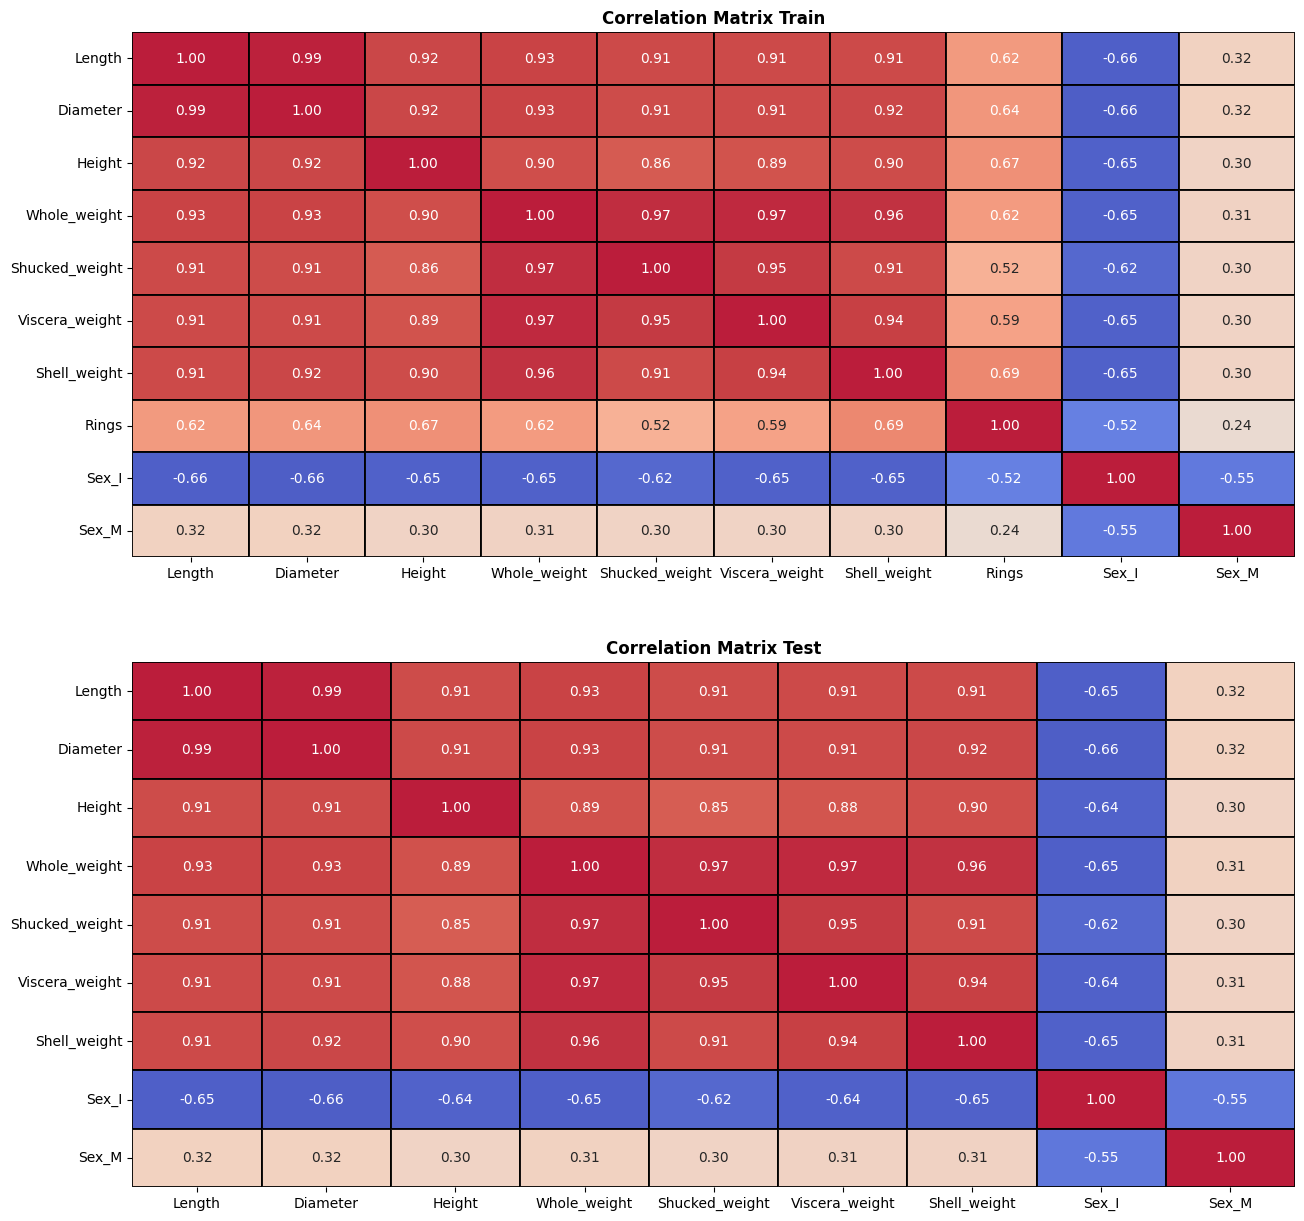

In [19]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(211)
corr_matrix_train = utilities.plot_correlation_matrix_heatmap(ax, df_train.drop(columns= ['id']), 
                                                              cmap='coolwarm', title_after=' Train')
ax = plt.subplot(212)
corr_matrix_test = utilities.plot_correlation_matrix_heatmap(ax, df_test.drop(columns= ['id']), 
                                                             cmap='coolwarm', title_after=' Test')

# Print Top 3 Correlations for each column
# for column in corr_matrix.columns:
#     print(f'\nTop 3 Correlations for {column}:')
#     dict_temp = corr_matrix[column].sort_values(ascending=False).to_dict()
    
#     for i, (key, value) in enumerate(list(dict_temp.items())[1:4], 1):
#         print(f'{i}. {key}: {value:.2f}')
    
#     print()

As we can see feature are highly related (it's not unlogical cause they are measurement of the body)

We don't have a lot of feature, so one of the goal will be to do some feature engineering to bring more complexity

### FEATURE ENGINEERING

In [20]:
if get_dummies_sex and add_interaction_shucked:
    # Add sex * shucked weight interaction term
    df_train['Sex_I_Shucked_weight'] = df_train['Sex_I'] * df_train['Shucked_weight']
    df_train['Sex_M_Shucked_weight'] = df_train['Sex_M'] * df_train['Shucked_weight']

    df_test['Sex_I_Shucked_weight'] = df_test['Sex_I'] * df_test['Shucked_weight']
    df_test['Sex_M_Shucked_weight'] = df_test['Sex_M'] * df_test['Shucked_weight']

if get_dummies_sex and add_interaction_shell_weight:
    # Add sex * shell weight interaction term
    df_train['Sex_I_Shell_weight'] = df_train['Sex_I'] * df_train['Shell_weight']
    df_train['Sex_M_Shell_weight'] = df_train['Sex_M'] * df_train['Shell_weight']

    df_test['Sex_I_Shell_weight'] = df_test['Sex_I'] * df_test['Shell_weight']
    df_test['Sex_M_Shell_weight'] = df_test['Sex_M'] * df_test['Shell_weight']

At first, we can add a weight (blood weight in that case) that is just the Whole weight - all others weights

In [21]:
if add_blood_weight_features:
    add_blood_weight = lambda row: row['Whole_weight'] - (row['Shell_weight'] + row['Shucked_weight'] + row['Viscera_weight'])

    df_train['Blood_weight'] = df_train.apply(add_blood_weight, axis=1)
    df_test['Blood_weight'] = df_test.apply(add_blood_weight, axis=1)

We can also add other ration and yield (from https://www.kaggle.com/competitions/playground-series-s4e4/discussion/494344?rvi=1)

In [24]:
if add_ratios_features:    
    compute_meat_yield = lambda row: row['Shucked_weight'] / (row['Whole_weight'] + row['Shell_weight'])
    compute_shell_ratio = lambda row: row['Shell_weight'] / row['Whole_weight']
    compute_weight_to_shucked_weight = lambda row: row['Whole_weight'] / row['Shucked_weight'] if row['Shucked_weight'] != 0 else 0
    compute_viscera_ratio = lambda row: row['Viscera_weight'] / row['Whole_weight']
    compute_square_shucked = lambda row: row['Shucked_weight'] ** 2

    ratio_functions = {"Meat_Yield": compute_meat_yield, "Shell_Ratio": compute_shell_ratio, 
                    "Weight_to_Shucked_Weight": compute_weight_to_shucked_weight, "Viscera_Ratio": compute_viscera_ratio}


    for key, func in ratio_functions.items():
        df_train[key] = df_train.apply(func, axis=1)
        df_test[key] = df_test.apply(func, axis=1)

Despite the pertinence of these new features, they seem to reduce the performance of the model, so we wont use them for now!

In [22]:
df_train.head()

,id,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_I,Sex_M
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,False,False
1,1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,False,False
2,2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,True,False
3,3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,False,True
4,4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,True,False


### KEEP RELEVANT FEATURE AND SPLIT DATA

In [23]:
X = df_train.drop(columns=['id', 'Rings'], axis=1)
y = df_train['Rings']

X_test = df_test.drop(columns=['id'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### SCALING THE DATA

In [25]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_test_scaled = scaler.transform(X_test)

df_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
df_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
df_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

### HYPERPARAMETERS TUNING

In [26]:
if perform_grid_search:
    def rmsle(y_true, y_pred):
        assert len(y_true) == len(y_pred)
        return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

    # Make a scorer from the RMSLE function
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [27]:
if perform_grid_search:
    results = {}

    models = {
        'XGBoost': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators': [200, 250, 300, 350, 400],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.1, 0.15, 0.2],
            },
        },
        'Random Forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [100, 300, 500],
                'max_depth': [None, 10, 30],
            },
        },
        'CatBoost': {
            'model': CatBoostRegressor(),
            'params': {
                'iterations': [100, 300],
                'depth': [4, 8],
                'learning_rate': [0.01, 0.1],
            },
        },
        'SVR': {
            'model': SVR(),
            'params': {
                'kernel': ['linear', 'rbf'],
                'C': [0.1, 10],
            },
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(),
            'params': {
                'n_estimators': [100, 300, 500],
                'learning_rate': [0.01, 0.1, 0.3],
                'max_depth': [3, 5],
            },
        },
        'Neural Network': {
            'model': MLPRegressor(),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (100, 50)],
                'activation': ['logistic', 'relu'],
                'solver': ['adam'],
                'alpha': [0.0001, 0.001],
                'learning_rate': ['constant', 'adaptive']
            },
        }
    }

    for model_name, model_info in tqdm(models.items(), desc="Grid Searching"):
        print(f"Grid searching {model_name}...")
        model = model_info['model']
        params = model_info['params']
        
        grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1, scoring=rmsle_scorer)
        grid_search.fit(X_train_scaled, y_train)

        results[model_name] = {
            'model': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }

In [28]:
if not perform_grid_search:
    xgb_best_params = {
        'eta': 0.1006321838798394,
        'max_depth': 6,
        'min_child_weight': 27.999752791085136,
        'subsample': 0.7344797943645852,
        'colsample_bytree': 0.5389765810810496,
        'lambda': 79.62358968148187,
        'n_estimators': 407
    }

    lgbm_params = {
        'learning_rate': 0.04090453688322824,
        'n_estimators': 788,
        'reg_lambda': 29.248167932522765,
        'reg_alpha': 0.4583079398945705,
        'max_depth': 19,
        'colsample_bytree': 0.5439642175304692,
        'subsample': 0.8659762900446526,
        'min_child_samples': 12,
        'num_leaves': 69,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    lgbm_params_2 = {
        'n_jobs': -1,
        'verbose': -1,
        'max_depth': 20,
        'num_leaves': 165,
        'subsample_freq': 1,
        'random_state': 42,
        'n_estimators': 1460,
        'min_child_samples': 25,
        'reg_lambda': 6.13475387151606,
        'subsample': 0.8036874216939632,
        'reg_alpha': 0.3152990674231573,
        'learning_rate': 0.009336479469693189,
        'colsample_bytree': 0.5780931837049811,
        'min_child_weight': 0.37333232256934057,
    }

    cb_params_1 = {
        'grow_policy': 'SymmetricTree', 
        'n_estimators': 1000, 
        'learning_rate': 0.128912681527133, 
        'l2_leaf_reg': 1.836927907521674, 
        'max_depth': 6, 
        'colsample_bylevel': 0.6775373040510968, 
        'random_strength': 0, 
        'boost_from_average': True, 
        'loss_function': 'RMSE', 
        'verbose': False
        }

    cb_params_2 = {
        'depth': 15, 
        'verbose': 0,
        'max_bin': 464, 
        'verbose': False,
        'random_state':42,
        'task_type': 'CPU', 
        'random_state': 42,
        'min_data_in_leaf': 78, 
        'loss_function': 'RMSE', 
        'grow_policy': 'Lossguide', 
        'bootstrap_type': 'Bernoulli', 
        'subsample': 0.83862137638162, 
        'l2_leaf_reg': 8.365422739510098, 
        'random_strength': 3.296124856352495, 
        'learning_rate': 0.09992185242598203,
    }

    rf_params = {
        'n_estimators': 233,
        'max_features': 'sqrt',
        'max_depth': 45,
        'min_samples_split': 20,
        'min_samples_leaf': 10,
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    }

In [29]:
if not perform_grid_search:
    model_xgb = XGBRegressor(**xgb_best_params)
    model_lgbm = LGBMRegressor(**lgbm_params)
    model_lgbm_2 = LGBMRegressor(**lgbm_params_2)
    model_cb_1 = CatBoostRegressor(**cb_params_1)
    model_cb_2 = CatBoostRegressor(**cb_params_2)
    model_rf = RandomForestRegressor(**rf_params)

    model_xgb.fit(X_train_scaled, y_train)
    model_lgbm.fit(X_train_scaled, y_train)
    model_lgbm_2.fit(X_train_scaled, y_train)
    model_cb_1.fit(X_train_scaled, y_train)
    model_cb_2.fit(X_train_scaled, y_train)
    model_rf.fit(X_train_scaled, y_train)

    y_pred_xgb = model_xgb.predict(X_val_scaled)
    y_pred_lgbm = model_lgbm.predict(X_val_scaled)
    y_pred_lgbm_2 = model_lgbm_2.predict(X_val_scaled)
    y_pred_cb_1 = model_cb_1.predict(X_val_scaled)
    y_pred_cb_2 = model_cb_2.predict(X_val_scaled)
    y_pred_rf = model_rf.predict(X_val_scaled)

    rmsle_xgb = np.sqrt(mean_squared_log_error(y_val, y_pred_xgb))
    rmsle_lgbm = np.sqrt(mean_squared_log_error(y_val, y_pred_lgbm))
    rmsle_lgbm_2 = np.sqrt(mean_squared_log_error(y_val, y_pred_lgbm_2))
    rmsle_cb_1 = np.sqrt(mean_squared_log_error(y_val, y_pred_cb_1))
    rmsle_cb_2 = np.sqrt(mean_squared_log_error(y_val, y_pred_cb_2))
    rmsle_rf = np.sqrt(mean_squared_log_error(y_val, y_pred_rf))

    print(f"RMSLE XGBoost: {rmsle_xgb}")
    print(f"RMSLE LightGBM: {rmsle_lgbm}")
    print(f"RMSLE LightGBM 2: {rmsle_lgbm_2}")
    print(f"RMSLE CatBoost 1: {rmsle_cb_1}")
    print(f"RMSLE CatBoost 2: {rmsle_cb_2}")
    print(f"RMSLE Random Forest: {rmsle_rf}")

RMSLE XGBoost: 0.14947852785441682
RMSLE LightGBM: 0.14898234852205797
RMSLE LightGBM 2: 0.14863777108490459
RMSLE CatBoost 1: 0.14944536023969485
RMSLE CatBoost 2: 0.14882285893804306
RMSLE Random Forest: 0.15009118555522274


In [30]:
# Perform ensembling vote
y_pred_vote = np.mean([y_pred_xgb, y_pred_lgbm, y_pred_lgbm_2, y_pred_cb_1, y_pred_cb_2], axis=0)
rmsle_vote = np.sqrt(mean_squared_log_error(y_val, y_pred_vote))

print(f"RMSLE Vote: {rmsle_vote}")

RMSLE Vote: 0.14828742645287618


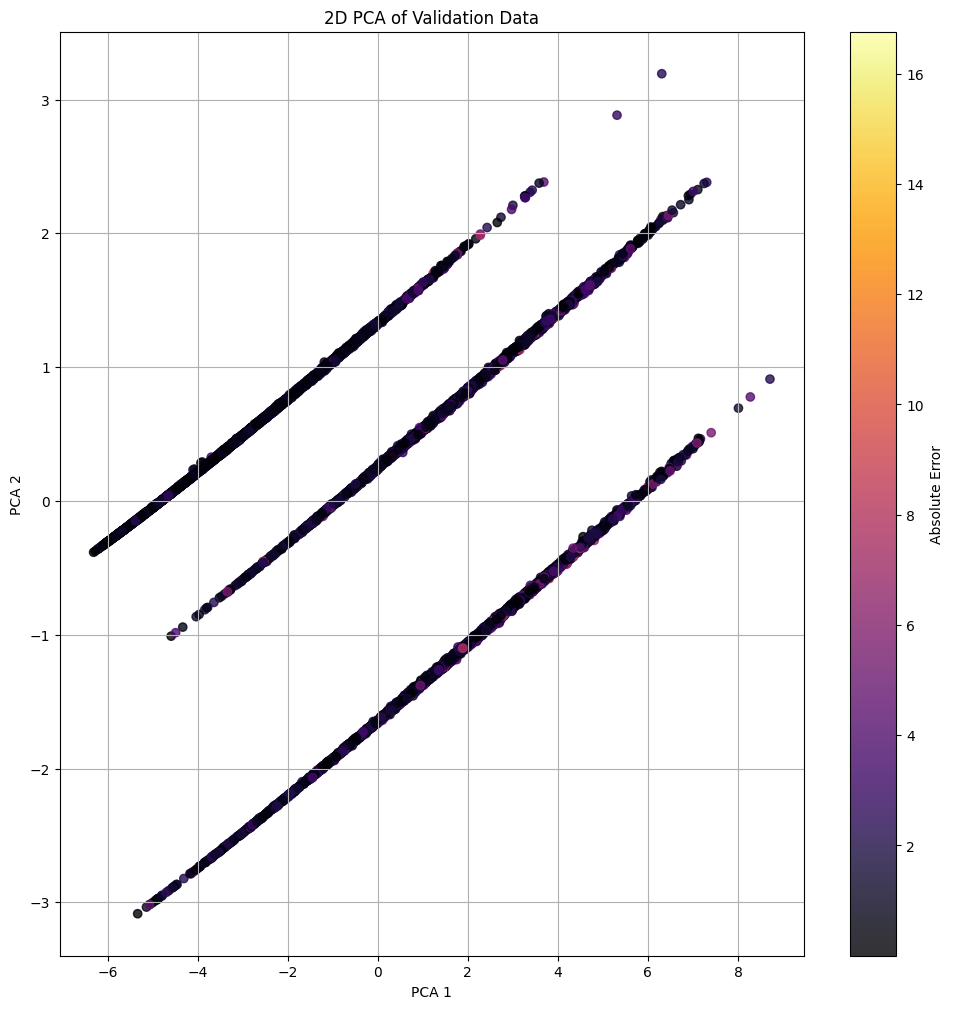

In [31]:
# Perform 2D PCA to visualize incorrect predictions
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_scaled)

# Calculate absolute errors
abs_errors = np.abs(y_pred_vote - y_val)

# Define colormap
cmap = colormaps["inferno"]

# Plotting
plt.figure(figsize=(12, 12))
sc = plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], c=abs_errors, cmap=cmap, alpha=0.8)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA of Validation Data')
plt.colorbar(sc, label='Absolute Error')
plt.grid(True)
plt.show()


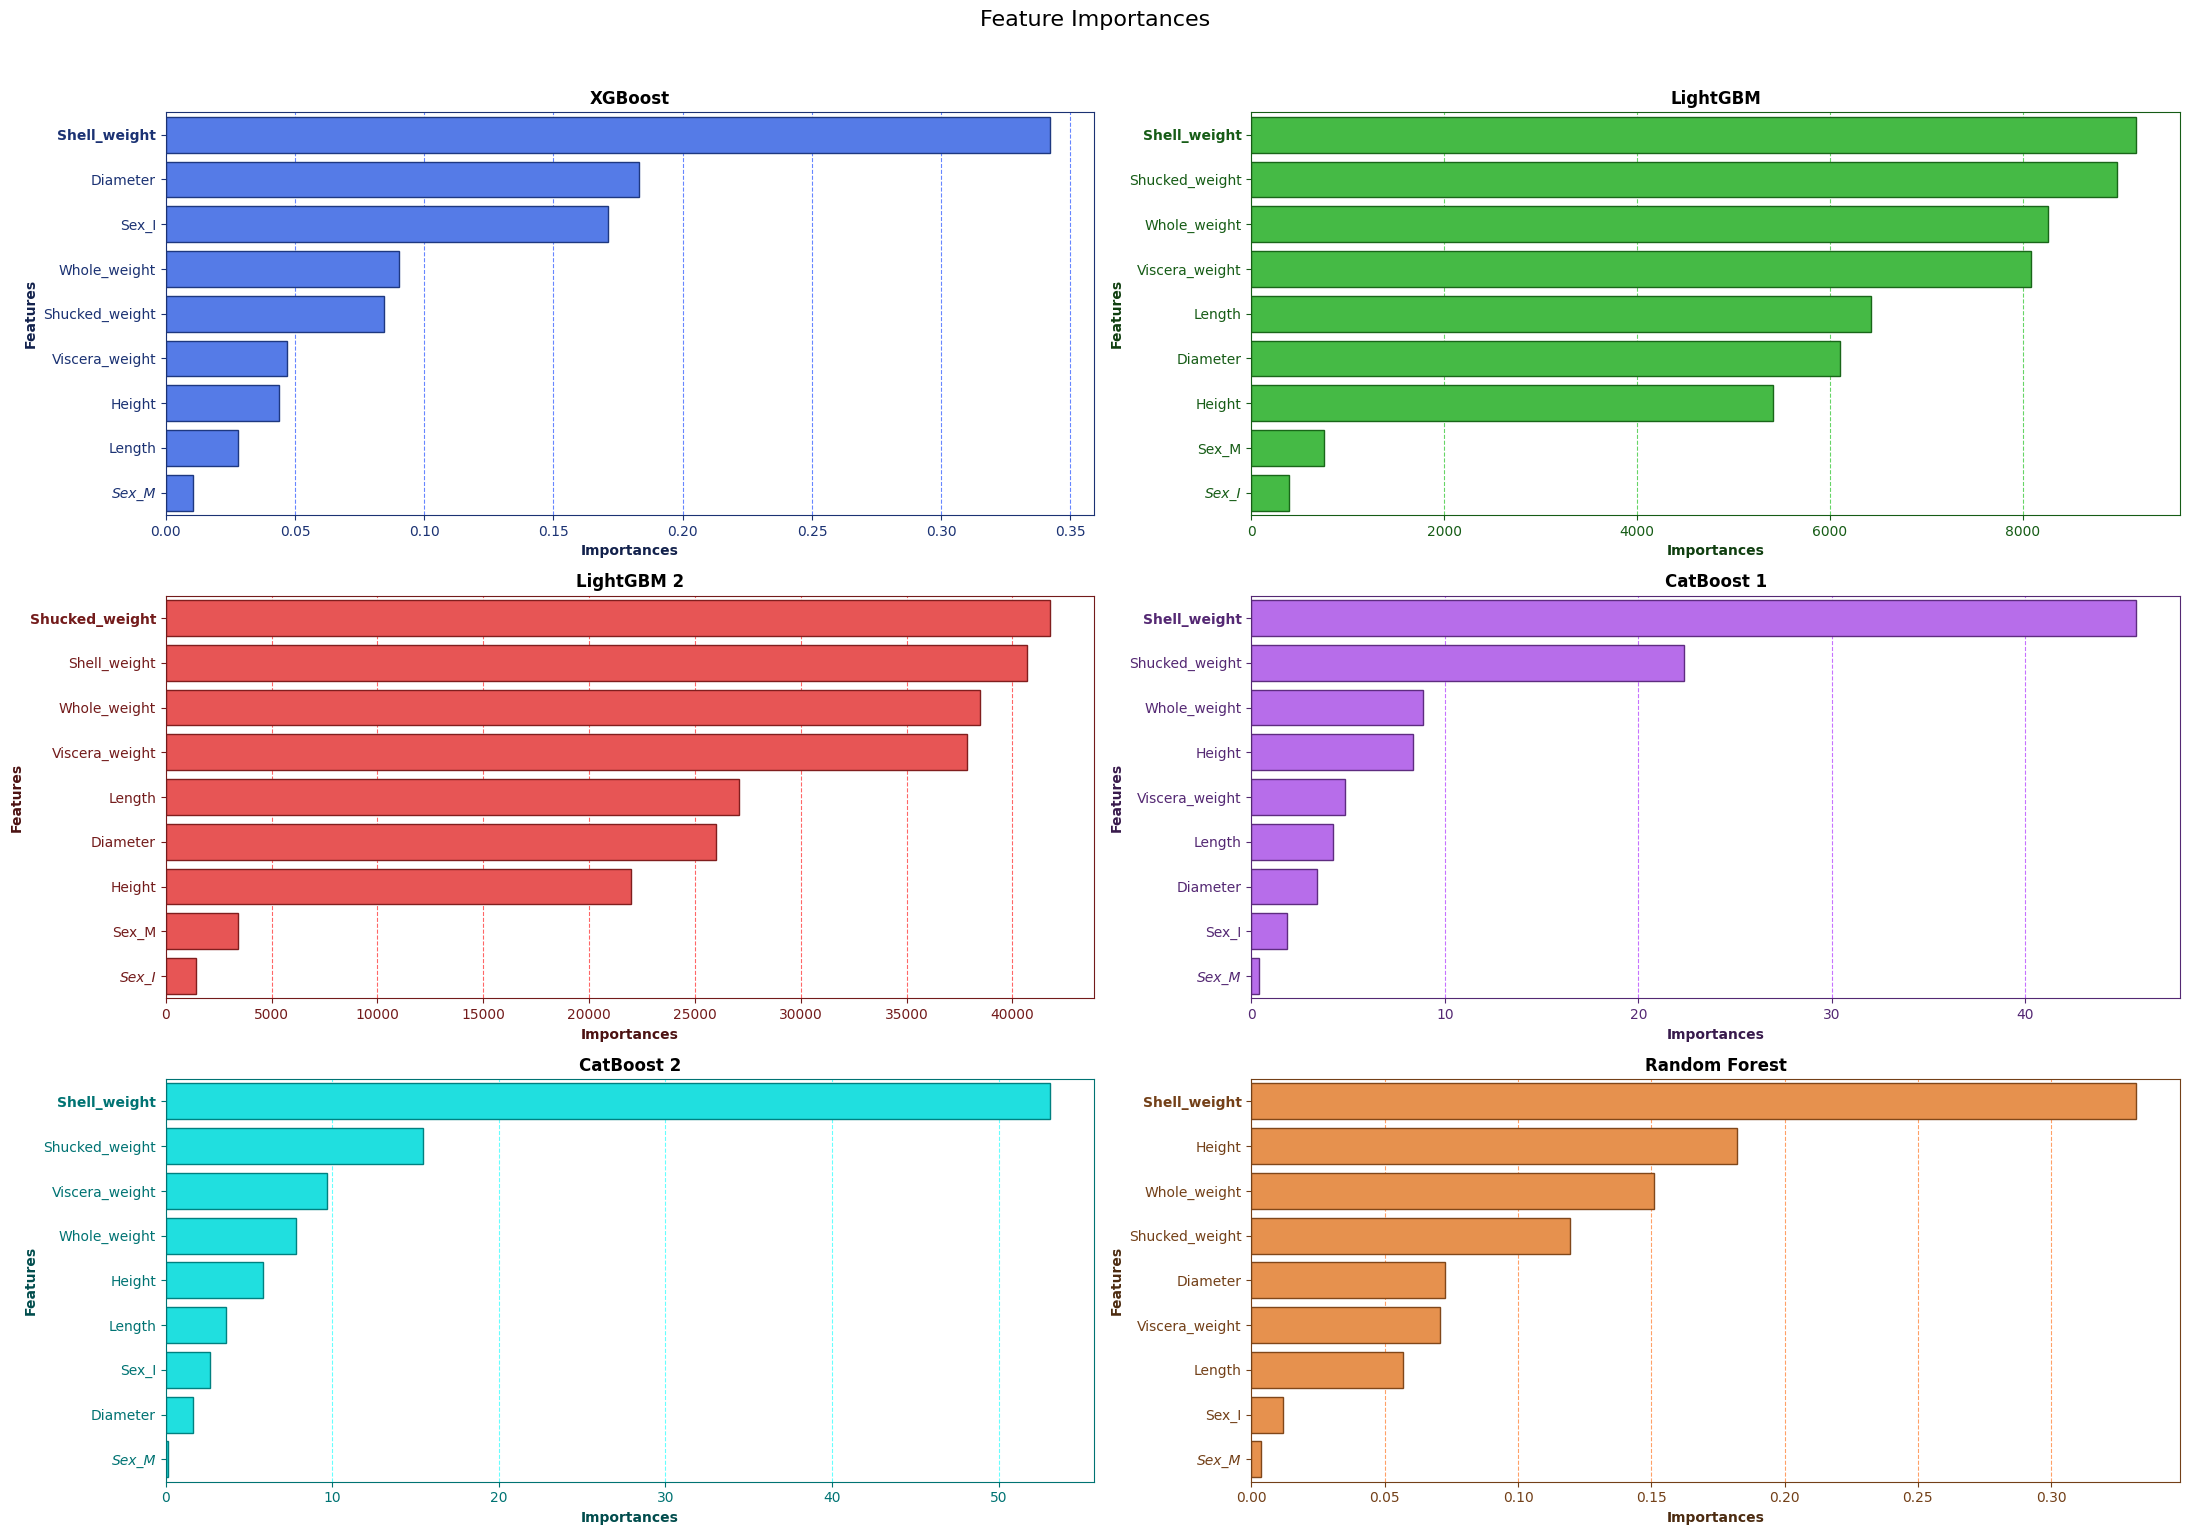

In [32]:
# get feature importance
importances_xgb = model_xgb.feature_importances_
importances_lgbm = model_lgbm.feature_importances_
importances_lgbm_2 = model_lgbm_2.feature_importances_
importances_cb_1 = model_cb_1.feature_importances_
importances_cb_2 = model_cb_2.feature_importances_
importances_rf = model_rf.feature_importances_

plt.figure(figsize=(22, 15))
plt.suptitle('Feature Importances', fontsize=16, y=1.02)
plt.subplots_adjust(top=1)
ax = plt.subplot(3, 2, 1)
utilities.plot_feature_importance(ax, X.columns, importances_xgb, title='XGBoost', color=COLORS['BLUE'])
ax = plt.subplot(3, 2, 2)
utilities.plot_feature_importance(ax, X.columns, importances_lgbm, title='LightGBM', color=COLORS['GREEN'])
ax = plt.subplot(3, 2, 3)
utilities.plot_feature_importance(ax, X.columns, importances_lgbm_2, title='LightGBM 2', color=COLORS['RED'])
ax = plt.subplot(3, 2, 4)
utilities.plot_feature_importance(ax, X.columns, importances_cb_1, title='CatBoost 1', color=COLORS['PURPLE'])
ax = plt.subplot(3, 2, 5)
utilities.plot_feature_importance(ax, X.columns, importances_cb_2, title='CatBoost 2', color=COLORS['CYAN'])
ax = plt.subplot(3, 2, 6)
utilities.plot_feature_importance(ax, X.columns, importances_rf, title='Random Forest', color=COLORS['ORANGE'])
plt.tight_layout()


### CSV RESULT

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Generate CSV file for submission with ensembling votes
model_xgb.fit(X_scaled, y)
model_lgbm.fit(X_scaled, y)
model_lgbm_2.fit(X_scaled, y)
model_cb_1.fit(X_scaled, y)
model_cb_2.fit(X_scaled, y)

y_pred_xgb_test = model_xgb.predict(X_test_scaled)
y_pred_lgbm_test = model_lgbm.predict(X_test_scaled)
y_pred_lgbm_2_test = model_lgbm_2.predict(X_test_scaled)
y_pred_cb_1_test = model_cb_1.predict(X_test_scaled)
y_pred_cb_2_test = model_cb_2.predict(X_test_scaled)

y_pred_vote_test = np.mean([y_pred_xgb_test, y_pred_lgbm_test, y_pred_lgbm_2_test, y_pred_cb_1_test, y_pred_cb_2_test], axis=0)

df_submission = pd.DataFrame({'id': df_test['id'], 'Rings': y_pred_vote_test})
df_submission.to_csv('submission.csv', index=False)